# [복습 과제1] 2024년 8월 '양궁' 관련 뉴스 본문 수집하기

1. 앞서 제시한 코드를 활용하여, '양궁' 분야 URL을 가지고 옵니다. ('PARIS NOW > '뉴스' > '양궁'을 클릭합니다.)
2. 날짜 범위를 2024년 8월로 조정합니다. 수집해야 할 일별 뉴스는 30개입니다.
3. '제목', '링크'에 추가로 '조회수'를 파싱해 리스트로 생성합니다.
4. `discipline_list` 리스트를 생성하고, 뉴스 길이만큼 'ARC'로 값을 채워 데이터 프레임에 컬럼을 하나 더 추가합니다.
5. 최종적으로 '제목', 'URL', '조회수', '날짜', '종목' 5개의 컬럼을 생성한 데이터프레임을 만들어 CSV 파일을 추출합니다. Slack 채널에는 데이터프레임 이미지를 캡처해 댓글로 업로드합니다.

In [18]:
# 필요한 라이브러리는 미리 불러옵니다.
from selenium import webdriver
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
import sys
from selenium.webdriver.common.keys import Keys
import urllib.request
import os
from urllib.request import urlretrieve

import time
import pandas as pd
import chromedriver_autoinstaller  # setup chrome options
from bs4 import BeautifulSoup

In [2]:
chrome_options = webdriver.ChromeOptions()
driver = webdriver.Chrome(options=chrome_options)

In [3]:
url = 'https://m.sports.naver.com/paris2024/news?disciplineId=ARC&date=20240803&sort=popular&isPhoto=Nhttps://m.sports.naver.com/paris2024/news?disciplineId=ARC&date=20240803&sort=popular&isPhoto=N'
driver.get(url)

'<html lang="ko" data-useragent="Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/127.0.0.0 Safari/537.36"><head><meta charset="utf-8"><meta http-equiv="X-UA-Compatible" content="IE=edge"><meta name="viewport" content="width=device-width,initial-scale=1,maximum-scale=1,minimum-scale=1,user-scalable=no"><title>PARIS NOW : 네이버스포츠</title><link rel="shortcut icon" type="image/x-icon" href="https://sports-phinf.pstatic.net/mobile/favicon/20240422/android/android_192X192.png"><link rel="apple-touch-icon" href="https://sports-phinf.pstatic.net/mobile/favicon/20240422/ios/ios_57X57.png"><link rel="apple-touch-icon" sizes="76x76" href="https://sports-phinf.pstatic.net/mobile/favicon/20240422/ios/ios_76X76.png"><link rel="apple-touch-icon" sizes="120x120" href="https://sports-phinf.pstatic.net/mobile/favicon/20240422/ios/ios_120X120.png"><link rel="apple-touch-icon" sizes="152x152" href="https://sports-phinf.pstatic.net/mobile/favicon/20240422/ios/ios_152X1
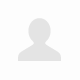
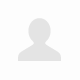

In [4]:
html = driver.page_source
html

<html data-useragent="Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/127.0.0.0 Safari/537.36" lang="ko"><head><meta charset="utf-8"/><meta content="IE=edge" http-equiv="X-UA-Compatible"/><meta content="width=device-width,initial-scale=1,maximum-scale=1,minimum-scale=1,user-scalable=no" name="viewport"/><title>PARIS NOW : 네이버스포츠</title><link href="https://sports-phinf.pstatic.net/mobile/favicon/20240422/android/android_192X192.png" rel="shortcut icon" type="image/x-icon"/><link href="https://sports-phinf.pstatic.net/mobile/favicon/20240422/ios/ios_57X57.png" rel="apple-touch-icon"/><link href="https://sports-phinf.pstatic.net/mobile/favicon/20240422/ios/ios_76X76.png" rel="apple-touch-icon" sizes="76x76"/><link href="https://sports-phinf.pstatic.net/mobile/favicon/20240422/ios/ios_120X120.png" rel="apple-touch-icon" sizes="120x120"/><link href="https://sports-phinf.pstatic.net/mobile/favicon/20240422/ios/ios_152X152.png" rel="apple-touch-icon" si
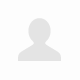
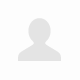

In [5]:
from bs4 import BeautifulSoup
soup = BeautifulSoup(html, 'html.parser')
soup

In [19]:
soup = BeautifulSoup(html, 'html.parser')

In [20]:
date_range = pd.date_range('2024-08-01', '2024-08-05').strftime('%Y%m%d')
date_range

Index(['20240801', '20240802', '20240803', '20240804', '20240805'], dtype='object')

In [32]:
from tqdm.auto import tqdm
import re

discipline_list =[]

for date in tqdm(date_range):
    url = f'https://m.sports.naver.com/paris2024/news?disciplineId=ARC&date={date}&sort=popular&isPhoto=N'
    driver.get(url)
    time.sleep(2)

    news_more_button = driver.find_element(By.XPATH, '//*[@id="content"]/div[2]/div/div[1]/div[1]/div[2]/button')

    n=0
    for i in range(2):
        try : 
            news_more_button.click()
            time.sleep(2)
            n+=1
            print(f'{date}:{n}회 클릭함')
        except:
            next
    
    html = driver.page_source
    soup = BeautifulSoup(html, 'html.parser')

    news_section = soup.find('div', re.compile('NewsList_comp_news_list'))
    news_tag_list = news_section.find_all('li', re.compile('NewsList'))

    news_title_list = list(map(lambda x : x.find('span', re.compile('NewsList_title')).text, news_tag_list))
    news_url_list = list(map(lambda x : x.find('a', re.compile('NewsList_link')).get('href'), news_tag_list))
    news_view_list = list(map(lambda x : x.find('span', re.compile('NewsList_data')).text, news_tag_list))
    # news_viewnum_list = list(map(lambda x : re.sub(r'[^\\d]', '', x), news_view_list))

    date_list = [date]*len(news_title_list)

    daily_news_list = list(zip(news_title_list, news_url_list, news_view_list, date_list))
    discipline_list.extend(daily_news_list)


  0%|          | 0/5 [00:00<?, ?it/s]

20240801:1회 클릭함


 20%|██        | 1/5 [00:07<00:29,  7.44s/it]

20240801:2회 클릭함
20240802:1회 클릭함


 40%|████      | 2/5 [00:13<00:20,  6.87s/it]

20240802:2회 클릭함
20240803:1회 클릭함
20240803:2회 클릭함


 60%|██████    | 3/5 [00:24<00:17,  8.61s/it]

20240804:1회 클릭함


 80%|████████  | 4/5 [00:31<00:07,  7.89s/it]

20240804:2회 클릭함
20240805:1회 클릭함


100%|██████████| 5/5 [00:37<00:00,  7.57s/it]

20240805:2회 클릭함


In [35]:
daily_news_list

[('‘3관왕’ 김우진 “메달 땄다고 젖지 말라, 해 뜨면 마른다”',
  '/paris2024/article/028/0002701244',
  '조회수 153,563',
  '20240805'),
 ('“한국 양궁은 왜 강한가”… 고구려 역사 꺼낸 日기자',
  '/paris2024/article/005/0001715567',
  '조회수 140,807',
  '20240805'),
 ('김우진 위협한 엘리슨 알고보니... 韓지도자가 키운 ‘태극궁사 킬러’',
  '/paris2024/article/023/0003850626',
  '조회수 130,515',
  '20240805'),
 ('“한국 킬러였는데, 매너 짱”…양궁 ‘금메달’ 김우진에 美선수가 한 행동',
  '/paris2024/article/009/0005345333',
  '조회수 110,336',
  '20240805'),
 ('“디카프리오 닮은 美선수 호감” 패배 후 양궁 金 김우진에 축하건네',
  '/paris2024/article/020/0003580308',
  '조회수 108,772',
  '20240805'),
 ('최후의 한발 4.9㎜차 승리… 김우진, 한국 첫 金 5개 ‘신화’',
  '/paris2024/article/020/0003580230',
  '조회수 106,127',
  '20240805'),
 ('"김우진과 명승부 \'양궁아재\', 과거엔 디캐프리오였네"[파리올림픽]',
  '/paris2024/article/277/0005454912',
  '조회수 104,985',
  '20240805'),
 ("[올림픽] '김우진 양궁 3관왕' 한국 10번째 금메달…복싱 임애지 3위(종합)",
  '/paris2024/article/001/0014854014',
  '조회수 103,789',
  '20240805'),
 ('"외신도 감탄‥대체 비결 뭔가?" 정의선 "가장 중요한 건.."',
  '/paris2024/article/214/0001365843',
  '조회수 

In [36]:
df2 = pd.DataFrame(discipline_list, columns=['title', 'url', 'view', 'date'])
df2['view'] = df2['view'].apply(lambda x:re.sub(r'[^\d]', '', x.replace('조회수 ', '')))
df2['type'] = 'ARC' ;df2

,title,url,view,date,type
0,"""'미스터 오' 덕분""…단체전 첫 메달 딴 프랑스 양궁, 한국 감독 '찬사'",/paris2024/article/008/0005071562,189984,20240801,ARC
1,양궁 김우진 옆 1점 쏜 차드 선수 “고마워요 한국”,/paris2024/article/005/0001715059,118678,20240801,ARC
2,"""김제덕 보려고 안 잤는데""…양궁 개인전 우천으로 연기",/paris2024/article/025/0003377141,96499,20240801,ARC
3,프랑스 양궁 선수가 꼽는 ‘한국 양궁 신화’ 비결은? [특파원 리포트],/paris2024/article/056/0011773197,86841,20240801,ARC
4,‘양궁 최강’ 韓엔 졌지만… 中-佛 은메달도 한국인이 이끌었다,/paris2024/article/020/0003579663,59871,20240801,ARC
...,...,...,...,...,...
145,"6년 전에도 졌는데 이번에도 진 이우석 ""우진이형, 오히려 고맙다""",/paris2024/article/008/0005072761,49770,20240805,ARC
146,"'한국은 활의 민족이냐'는 일본 기자, 김우진의 대답은 달랐다",/paris2024/article/047/0002441956,47085,20240805,ARC
147,'신궁의 나라'...한국 양궁 사상 첫 5종목 석권,/paris2024/article/052/0002070103,45353,20240805,ARC
148,'최강 양궁' 김우진이 쏜 韓 10번째 금메달…12년 만 두 자릿수 金[파리 2024],/paris2024/article/003/0012709304,44358,20240805,ARC


In [52]:
# CSV 데이터 저장하기

# import os

# path = '/content/drive/MyDrive/' # YOUR_PATH
# file_name = f'파리올림픽_네이버_뉴스_{date_range[0]}_{date_range[-1]}.csv'

df2.to_csv("2강과제dataframe.csv")

# [복습 과제2] 뉴스 본문 수집하기

1. 앞서 실습에서 진행한 데이터프레임을 불러와 학습한 개념을 응용해 각 URL로 접속하여 뉴스 본문을 수집합니다.
2. 제목, (입력) 날짜, 본문, 언론사 정보, URL을 하나의 데이터프레임으로 생성해 추출합니다.
3. 최종적으로 '제목', '날짜', '본문', '언론사', 'url' 5개의 컬럼을 생성한 데이터프레임을 만들어 CSV 파일을 추출합니다. Slack 채널에는 데이터프레임 이미지를 캡처해 댓글로 업로드합니다.

In [37]:
chrome_options = webdriver.ChromeOptions()
driver = webdriver.Chrome(options=chrome_options)

In [44]:
url_list = df2['url']

from tqdm.auto import tqdm

total_data_list = []

for i in tqdm(url_list) :
    driver.get(f'https://m.sports.naver.com{i}')
    time.sleep(2)

    html = driver.page_source
    soup = BeautifulSoup(html, 'html.parser')

    news_title = soup.find('h2').text
    date = soup.find('em', re.compile('NewsEndMain_date')).text[0:10]
    content = soup.find('div', re.compile('_article_content')).text
    press = soup.find('a', re.compile('NewsEndMain_article_head_press_logo__')).img.get('alt')
    data = (news_title, date, content, press, i)
    total_data_list.append(data)


100%|██████████| 150/150 [05:49<00:00,  2.33s/it]


In [45]:
len(total_data_list)

150

In [46]:
total_data_list[0]

('"\'미스터 오\' 덕분"…단체전 첫 메달 딴 프랑스 양궁, 한국 감독 \'찬사\'',
 '2024.08.01',
 '대한민국 양궁대표팀 김우진, 이우석, 김제덕이 지난 30일(한국시간) 프랑스 파리 앵발리드에서 열린 2024 파리올림픽 양궁 남자 단체전 시상식에서 금메달을 목에 건 후 프랑스(은메달), 터키(동메달) 선수들과 기념촬영을 하고 있다. /사진=뉴스1 프랑스가 남자 양궁 단체전에서 사상 최초로 메달을 획득한 것을 두고 외신은 물론, 프랑스 현지에서도 한국 감독 덕분이라는 찬사가 쏟아지고 있다. 1일 프랑스 일간신문인 르몽드는 지난달 28일 프랑스 양궁협회가 올해 2024 파리올림픽을 앞두고 최소한 하나의 메달 획득을 목표로 전례 없는 지원을 퍼부으면서 한국인 감독을 선임해 효과를 봤다고 보도했다. 프랑스 남자 단체전 은메달을 이끈 한국인 감독은 \'미스터 오(Mr. Oh)\'로 알려진 오선택 감독이다. 르몽드는 오 감독에 대해 업계에서 잘 알려진 사람이라고 보도했다. 그가 2000년과 2012년 두 차례에 걸쳐 한국 국가대표팀 감독을 맡았고 2000년 시드니(호주)의 윤미진, 2012년 런던의 오진혁, 2016년의 장혜진 등 여러 선수들을 올림픽 시상대 가장 높은 곳에 올려놨다고 소개했다. 한국은 양궁의 \'기준점\'이고, 1972년 뮌헨올림픽에서 양궁이 올림픽 정식종목으로 복귀한 후 한국 대표팀이 전체 45개 종목 중 27개 종목에서 우승을 차지했다고도 보도했다. 프랑스 남자 양궁 대표팀 리더인 장 샤를 발라동(Jean-Charles Valladont)이 "한국은 우수한 양궁 선수들이 너무 많다"면서 "테디 리네르(프랑스의 세계 최강 유도선수)와 같은 스타들이 많고 완전히 다른 세상이다"고 인터뷰한 내용도 실었다. 프랑스 세바스티앙 플루트 양궁 센터에서 \'Mr. Oh\'로 알려진 한국의 오선택 감독올림픽 시뮬레이션을 하고 있다./사진=르몽드 캡처그러면서 한국 양궁의 성공 역사는 1988년 서울올림픽 유치에 뿌리를 두고 있다고도 분석했다. 한

In [47]:
df3 = pd.DataFrame(total_data_list, columns = ['title', 'date', 'content', 'press' , 'url']); df3

,title,date,content,press,url
0,"""'미스터 오' 덕분""…단체전 첫 메달 딴 프랑스 양궁, 한국 감독 '찬사'",2024.08.01,"대한민국 양궁대표팀 김우진, 이우석, 김제덕이 지난 30일(한국시간) 프랑스 파리 ...",머니투데이,/paris2024/article/008/0005071562
1,양궁 김우진 옆 1점 쏜 차드 선수 “고마워요 한국”,2024.08.01,2024 파리 올림픽 남자 양궁 개인전 64강에서 한국 남자 양궁 국가대표 김우진과...,국민일보,/paris2024/article/005/0001715059
2,"""김제덕 보려고 안 잤는데""…양궁 개인전 우천으로 연기",2024.08.01,김제덕이 지난 29일(현지시간) 프랑스 파리 레쟁발리드 양궁 경기장에서 열린 ...,중앙일보,/paris2024/article/025/0003377141
3,프랑스 양궁 선수가 꼽는 ‘한국 양궁 신화’ 비결은? [특파원 리포트],2024.08.01,한국 양궁 대표팀이 이번 파리올림픽 여자 단체전과 남자 단체전에서 잇따라 우승을 거...,KBS,/paris2024/article/056/0011773197
4,‘양궁 최강’ 韓엔 졌지만… 中-佛 은메달도 한국인이 이끌었다,2024.08.01,[PARiS 2024]출전한 해외 8개국 감독이 ‘코리안’… 韓 지도자 진출에 ‘양...,동아일보,/paris2024/article/020/0003579663
...,...,...,...,...,...
145,"6년 전에도 졌는데 이번에도 진 이우석 ""우진이형, 오히려 고맙다""",2024.08.05,김우진과 이우석이 4일(현지시각) 프랑스 파리 레쟁발리드에서 열린 2024 파리 올...,머니투데이,/paris2024/article/008/0005072761
146,"'한국은 활의 민족이냐'는 일본 기자, 김우진의 대답은 달랐다",2024.08.05,파리 올림픽 3관왕이 말하는 '양궁 강국' 이유 3가지▲ 4일(현지시간) 프랑스 ...,오마이뉴스,/paris2024/article/047/0002441956
147,'신궁의 나라'...한국 양궁 사상 첫 5종목 석권,2024.08.05,[앵커]우리 남녀 양궁은 이번 파리올림픽에 걸린 금메달 5개를 모두 가져오는 큰 성...,YTN,/paris2024/article/052/0002070103
148,'최강 양궁' 김우진이 쏜 韓 10번째 금메달…12년 만 두 자릿수 金[파리 2024],2024.08.05,"양궁 김우진, 통산 5개 금메달 역대 최다 新양궁 최초 5개 종목 석권…이우석은 동...",뉴시스,/paris2024/article/003/0012709304


In [51]:
df3.to_csv("2강과제2dataframe.csv")